## Import necessary libraries

In [153]:
%reset -f

import pandas as pd
import numpy
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import time
import pandas as pd
import os.path
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cv2 
from sklearn.metrics import mean_squared_log_error
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Image, display
import tensorflow
os.environ['PATH'] += ';C:\\Program Files\\Graphviz\\bin'
import graphviz
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder

# !pip install talos
import talos


def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

## Save environment parameters, so those won't be saved to report file

In [154]:
environment_variables = dir()

## Define model related constants

In [155]:
# Input parameters
# Input parameters
TRAINING_FILES = ["../data/original/training_dataset.csv"
, "..\data\preprocessed\difference_preprocessed_training_dataset.csv"
, "..\data\preprocessed\ole_RemoveOutliers_and_preprocessing_pipe_training_dataset.csv"]
EVALUATION_FILES = ["../data/original/evaluation_dataset.csv"
, "..\data\preprocessed\difference_preprocessed_evaluation_dataset.csv"
, "..\data\preprocessed\ole_RemoveOutliers_and_preprocessing_pipe_evaluation_dataset.csv"]

FILE_N = 2
INPUT_TRAINING_FILE = TRAINING_FILES[FILE_N] # "../data/original/training_dataset.csv"
INPUT_EVALUATION_FILE = EVALUATION_FILES[FILE_N] # "../data/original/evaluation_dataset.csv"


# Output parameters
METHOD_NAME = "keras_tensorflow_resnet"
TIMESTAMP = time.strftime("%d_%m_%Y-%H_%M_%S")
OUTPUT_MODEL_FOLDER = f"../data/models/keras_models"
OUTPUT_MODEL = f"../data/models/{METHOD_NAME}_model_{TIMESTAMP}.pkl"
OUTPUT_RESULTS = f"../data/results/{METHOD_NAME}_model_{TIMESTAMP}.txt"
OUTPUT_MODEL_ARCHITECTURE_RESULTS = f"../img/{METHOD_NAME}_model_{TIMESTAMP}.png"

# Hyper parameter alternatives
# Bankrupt companies must have higher weight, because there are fewer samples

# Hyper parameter optimization parameters
HYPER_PARAMETER_OPTIMIZATION_SCORING = "accuracy"
HYPER_PARAMETER_OPTIMIZATION_CV = 5

# Cross validation parameters
CROSS_VALIDATION_CV = 5

# Cost parameters
PUNISHMENT_FOR_FALSE_BANKRUPT_PREDICTION = 100

# Other constants
LABELS = ["Operational", "Bankrupt"]
RANDOM_SEED = 42

## Load the datasets
These dataset should contain "Bankrupt?" label and features that should be considered during learning.

In [156]:

training_dataset = pd.read_csv(INPUT_TRAINING_FILE, engine="python", delimiter=",")
training_features = training_dataset.loc[:, training_dataset.columns != "Bankrupt?"]
training_targets = training_dataset["Bankrupt?"]

evaluation_dataset = pd.read_csv(INPUT_EVALUATION_FILE, engine="python", delimiter=",")
evaluation_features = evaluation_dataset.loc[:, evaluation_dataset.columns != "Bankrupt?"]
evaluation_targets = evaluation_dataset["Bankrupt?"]

## Define the training pipeline

In [157]:
# # Create internal pipeline
# classifier = svm.SVC(class_weight=HYPER_PARAMETER_CLASS_WEIGHT, random_state=RANDOM_SEED)
# pipeline = Pipeline(steps=[("classification", classifier)])

# # Specify the tunable hyper parameters
# parameters = {
#     "classification__kernel": HYPER_PARAMETER_KERNEL,
#     "classification__gamma": HYPER_PARAMETER_GAMMA
# }

# # Define KFold parameters
# cv = StratifiedKFold(n_splits=HYPER_PARAMETER_OPTIMIZATION_CV, shuffle=True, random_state=42)

# estimator = GridSearchCV(pipeline, parameters,
#     scoring=HYPER_PARAMETER_OPTIMIZATION_SCORING, cv=cv)

In [158]:
# Define our keras-tensorflow architecture
def ResNet(n_in, n_out, neurons = 213 , n_activator = 'relu', f_activator = 'softmax'):
    input =tensorflow.keras.layers.Input(shape=(n_in,))

    output1 =tensorflow.keras.layers.Dense(n_in, input_shape=(n_in,), activation=n_activator)(input)
    output1 =tensorflow.keras.layers.BatchNormalization(axis=1, name='dense_relu' + '2a')(output1)
    dense_name_base = "dense"
    bn_name_base = "dense_additionall"
    shortcut1 =tensorflow.keras.layers.Dense(n_in, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '1')(output1)
    output2 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '2a')(output1)
    
    output2 =tensorflow.keras.layers.BatchNormalization(axis=1, name=bn_name_base + '2a')(output2)
    shortcut2 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '2')(output2)

    #     # Jump over neurons
    output2 =tensorflow.keras.layers.add([shortcut1, shortcut2])


    output3 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '2b')(output2)
    output3 =tensorflow.keras.layers.BatchNormalization(axis=1, name=bn_name_base + '2b')(output3)

    shortcut3 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '222')(output3)
    
    output4 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '2c')(output3)
    output4 =tensorflow.keras.layers.BatchNormalization(axis=1, name=bn_name_base + '2c')(output4)

    shortcut6 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '4')(output4)

    # Jump over neurons
    output =tensorflow.keras.layers.add([ output2,shortcut6 ])
    output =tensorflow.keras.layers.Dense(n_out, activation=f_activator, name='fc1000')(output)
    
    # Final model
    model =tensorflow.keras.models.Model(inputs=input, outputs=output)
    return model






## Do training

In [159]:
def train_fit_model(data_train,target_train, data_test,target_test, model, loss, optimizer, metrics, epochs = 250):

    # Plot model information
    plot_= True
    plot_model(model, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
    if plot_:
        plot_model(model, to_file=OUTPUT_MODEL_ARCHITECTURE_RESULTS, show_shapes=True, show_layer_names=True)
        im = cv2.imread(OUTPUT_MODEL_ARCHITECTURE_RESULTS, 0)
        model.summary()
        display(Image(filename=OUTPUT_MODEL_ARCHITECTURE_RESULTS))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    file_path = TIMESTAMP
    file_path = OUTPUT_MODEL_FOLDER + "/" + file_path
    if not os.path.exists(file_path):#os.path.join(OUTPUT_MODEL_FOLDER,file_path)):
        os.makedirs(file_path)
    
    checkpath = file_path
    os.makedirs(checkpath, exist_ok=True)
    checkpath = os.path.join(checkpath, METHOD_NAME + 'model-epoch{epoch:03d}-valloss{val_loss:03f}-acc{val_accuracy:03f}.h5')
    
    stopper = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=20, mode='auto')
    saver = ModelCheckpoint(checkpath, save_best_only=True, verbose=1, monitor='val_loss', mode='min')
    tensorflow.convert_to_tensor(data_train)
    tensorflow.convert_to_tensor(data_test)

    history = model.fit(data_train, target_train,
                      batch_size=64,
                      epochs=epochs,
                      verbose=2,
                      validation_data=((data_test), target_test),
                      callbacks=[saver, stopper])
                      
    return model, history

def ResNet2(n_in, n_out, neurons = 213 , n_activator = 'relu', f_activator = 'softmax'):
    input =tensorflow.keras.layers.Input(shape=(n_in,))

    output1 =tensorflow.keras.layers.Dense(n_in, input_shape=(n_in,), activation=n_activator)(input)
    output1 =tensorflow.keras.layers.BatchNormalization(axis=1, name='dense_relu' + '2a')(output1)
    dense_name_base = "dense"
    bn_name_base = "dense_additionall"
    shortcut1 =tensorflow.keras.layers.Dense(n_in, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '1')(output1)
    
    
    output1 =tensorflow.keras.layers.add([output1, shortcut1])#

        
    output2 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '2a')(output1)
    
    output2 =tensorflow.keras.layers.BatchNormalization(axis=1, name=bn_name_base + '2a')(output2)
    shortcut2 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '2')(output2)

    shortcut1 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '22')(output1)
#     # Jump over neurons
#     output2 =tensorflow.keras.layers.add([shortcut1, shortcut2])
    output2 =tensorflow.keras.layers.add([output2, shortcut2,shortcut1])

    output3 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '2b')(output2)
    output3 =tensorflow.keras.layers.BatchNormalization(axis=1, name=bn_name_base + '2b')(output3)

    shortcut3 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '222')(output3)
    
    
    output4 =tensorflow.keras.layers.add([output2,output3,shortcut1,shortcut2 , shortcut3 ])


    output4 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '2c')(output4)
    output4 =tensorflow.keras.layers.BatchNormalization(axis=1, name=bn_name_base + '2c')(output4)
    shortcut4 =tensorflow.keras.layers.Dense(neurons, activation='relu', kernel_initializer='he_normal',
                                    name=dense_name_base + '2222')(output4)

    output5 =tensorflow.keras.layers.add([output2,output3,output4,shortcut1,shortcut2 , shortcut3,shortcut4 ])
    shortcut6 =tensorflow.keras.layers.Dense(neurons, activation=n_activator, kernel_initializer='he_normal',
                                name=dense_name_base + '4')(output4)

    # Jump over neurons
    output =tensorflow.keras.layers.add([output2,output3,output4, output5,shortcut1,shortcut2 , shortcut3,shortcut4,shortcut6 ])

    output =tensorflow.keras.layers.Dense(n_out, activation=f_activator, name='fc1000')(output)
    
    # Final model
    model =tensorflow.keras.models.Model(inputs=input, outputs=output)
    return model

def simple_dense_model(n_in, n_out, neurons = 213 , n_activator = 'relu', f_activator = 'softmax', droput_val = 0, bn = False):
    inputs =tensorflow.keras.layers.Input(shape=(n_in,), dtype='float32', name='input_layer')  # Input (2 dimensions)

    outputs =tensorflow.keras.layers.Dense(n_in, activation=n_activator, name='hidden_layer_dense')(inputs)  # Hidden layer
    if bn:
        outputs = tensorflow.keras.layers.BatchNormalization()(outputs)
    outputs =tensorflow.keras.layers.Dropout(droput_val)(outputs)

    # outputs =tensorflow.keras.layers.Dense(20, activation=n_activator, name='hidden_layer_dense1')(outputs)  # Hidden layer
    # outputs =tensorflow.keras.layers.Dropout(droput_val)(outputs)
    # outputs = tensorflow.keras.layers.BatchNormalization()(outputs)


    outputs =tensorflow.keras.layers.Dense(n_in, activation=n_activator, name='hidden_layer_dense2')(outputs)  # Hidden layer
    if bn:
        outputs = tensorflow.keras.layers.BatchNormalization()(outputs)
    outputs =tensorflow.keras.layers.Dropout(droput_val)(outputs)

        
    outputs =tensorflow.keras.layers.Dense(n_out, activation=f_activator, name='output_layer')(outputs)  # Output layer (3 labels)

    # Completing the model structrure as a working model.
    # Užbaigiam modelio struktūrą kaip darbinį modelį.
    model =tensorflow.keras.models.Model(inputs=inputs, outputs=outputs, name='neural_network')

    return model

loss = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy', 'MeanSquaredError', 'AUC', "RootMeanSquaredError"]

# Build a model architecture
target_train = np.asarray(training_targets).astype('float32').reshape((-1,1))
target_test = np.asarray(evaluation_targets).astype('float32').reshape((-1,1))#
input_n = len(training_features.columns)

# Preparing the results input/output, for evaluation later on
oh_enc = OneHotEncoder(sparse=False)
target_train_OH = oh_enc.fit_transform(target_train)
target_test_OH = oh_enc.transform(target_test)

# Setting our model main parameters
model = simple_dense_model(input_n
                        , 2
                        , neurons = input_n 
                        , n_activator = 'relu'
                        , f_activator = 'sigmoid'
                        , droput_val = 0
                        , bn = True)

## Training our model

Model: "neural_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 95)]              0         
_________________________________________________________________
hidden_layer_dense (Dense)   (None, 95)                9120      
_________________________________________________________________
batch_normalization_39 (Batc (None, 95)                380       
_________________________________________________________________
dropout_41 (Dropout)         (None, 95)                0         
_________________________________________________________________
hidden_layer_dense2 (Dense)  (None, 95)                9120      
_________________________________________________________________
batch_normalization_40 (Batc (None, 95)                380       
_________________________________________________________________
dropout_42 (Dropout)         (None, 95)             

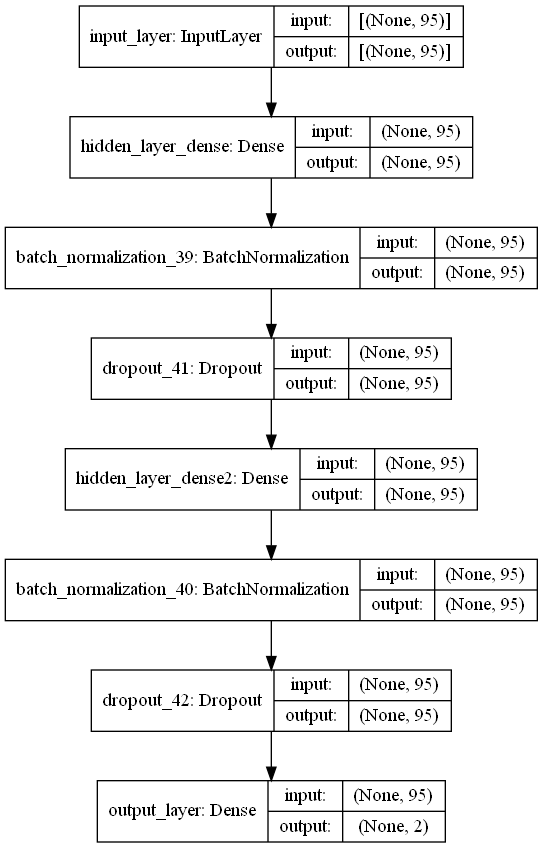

Epoch 1/100
79/79 - 8s - loss: 0.5872 - accuracy: 0.7885 - mean_squared_error: 0.1977 - auc: 0.8030 - root_mean_squared_error: 0.4447 - val_loss: 0.3906 - val_accuracy: 0.9457 - val_mean_squared_error: 0.1114 - val_auc: 0.9613 - val_root_mean_squared_error: 0.3337

Epoch 00001: val_loss improved from inf to 0.39061, saving model to ../data/models/keras_models/10_05_2022-23_50_35\keras_tensorflow_resnetmodel-epoch001-valloss0.390614-acc0.945748.h5
Epoch 2/100
79/79 - 2s - loss: 0.2938 - accuracy: 0.9603 - mean_squared_error: 0.0730 - auc: 0.9733 - root_mean_squared_error: 0.2702 - val_loss: 0.1875 - val_accuracy: 0.9670 - val_mean_squared_error: 0.0406 - val_auc: 0.9753 - val_root_mean_squared_error: 0.2014

Epoch 00002: val_loss improved from 0.39061 to 0.18746, saving model to ../data/models/keras_models/10_05_2022-23_50_35\keras_tensorflow_resnetmodel-epoch002-valloss0.187459-acc0.967009.h5
Epoch 3/100
79/79 - 2s - loss: 0.1672 - accuracy: 0.9653 - mean_squared_error: 0.0365 - auc: 0

In [160]:
estimator, history =  train_fit_model(training_features
                                    ,target_train_OH
                                    , evaluation_features
                                    , target_test_OH
                                    , model,loss
                                    , optimizer
                                    , metrics
                                    , epochs = 100)

In [161]:

# results = cross_val_score(pipeline, training_features
#                                     ,target_train, cv=kfold, verbose = 2)

## Calculate metric values

In [162]:
def confusion_matrix_to_string(cm):
    return f"True operational={cm[0][0]}, True bankrupt={cm[1][1]}, False operational={cm[0][1]}, False bankrupt={cm[1][0]}"

def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


    
# Use all training data to calculate confusion matrix for training data
training_estimates = estimator.predict(training_features)
training_estimates = np.argmax(training_estimates,axis=1)

training_accuracy = balanced_accuracy_score(training_targets, training_estimates)
training_confusion_matrix = confusion_matrix(training_targets, training_estimates)
training_confusion_matrix = confusion_matrix_to_string(training_confusion_matrix)


# Use model to estimate manually labeled evaluation Tweets
evaluation_estimates = estimator.predict(evaluation_features)
evaluation_estimates = np.argmax(evaluation_estimates,axis=1)
evaluation_accuracy = balanced_accuracy_score(evaluation_targets, evaluation_estimates)
evaluation_confusion_matrix = confusion_matrix(evaluation_targets, evaluation_estimates)
evaluation_confusion_matrix = confusion_matrix_to_string(evaluation_confusion_matrix)

print(f"Balanced training. acc: {training_accuracy}")
print(f"Balanced eval. acc: {evaluation_accuracy}")

Balanced training. acc: 0.5998966301426504
Balanced eval. acc: 0.5098484848484849


## Visualisation of our results

-- Model Specs --
  - Test Accuracy 0.9718675179569034 % 
  - RMSLE 0.11625977748284202  


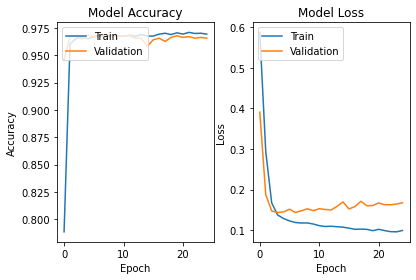

-- Model Specs --
  - Test Accuracy 0.9718675179569034 % 
  - RMSLE 0.11625977716564499  
[[4836    1]
 [ 140   35]]


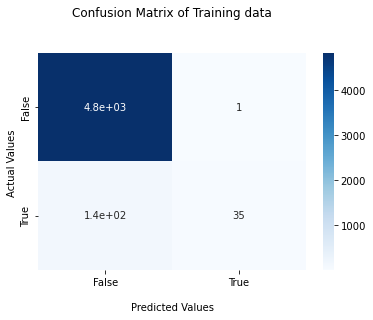

-- Model Specs --
  - Test Accuracy 0.9655425219941349 % 
  - RMSLE 0.1286670088248655  
[[1316    4]
 [  43    1]]


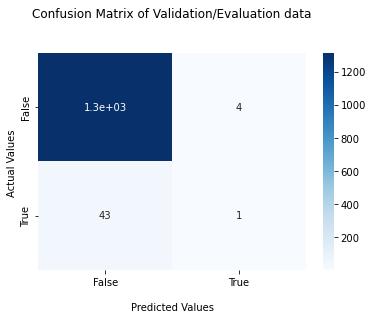

In [163]:
# Visualise the results
from sklearn.metrics import accuracy_score, f1_score

def print_model_acc(model, data_test, target_test, history):
    
    tensorflow.convert_to_tensor(data_test)
    data_test_reshape = np.asarray(data_test).astype('float32').reshape((-1,1))
    
    y_predictions = model.predict(data_test)
    predicted_classes = np.argmax(y_predictions,axis=1)
    np.set_printoptions(threshold=20)
    conf_matrix = confusion_matrix(target_test, predicted_classes)
    print('-- Model Specs --')
    print(f"  - Test Accuracy {accuracy_score(target_test, predicted_classes)} % ")
    print(f"  - RMSLE {RMSLE(target_test,predicted_classes)}  ")
    
    # Accuracy
    plt.subplot(1,2,1)
    
    plt.tight_layout()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Loss
    plt.subplot(1,2,2)
    
    plt.tight_layout()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


# , evaluation_features ,target_test, target_test_OH, training_features,target_train ,target_train_OH
print_model_acc(model, training_features, target_train, history)


from sklearn.metrics import confusion_matrix
def full_conf_mat(y_test, y_pred, data_title="Confusion Matrix of Training data"):
    
    print('-- Model Specs --')
    print(f"  - Test Accuracy {accuracy_score(y_test, y_pred)} % ")
    print(f"  - RMSLE {RMSLE(y_test,y_pred)}  ")

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(cf_matrix)
    import seaborn as sns
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title(f'{data_title}\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()
    
full_conf_mat(training_targets, training_estimates, "Confusion Matrix of Training data")

full_conf_mat(evaluation_targets, evaluation_estimates, "Confusion Matrix of Validation/Evaluation data")


In [164]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer
print("Training evaluation")
y_pred_train = estimator.predict(training_features) #prediction on our train 
y_pred_train = np.argmax(y_pred_train,axis=1)
print(classification_report(training_targets, y_pred_train))
train_conf_matrix = confusion_matrix(training_targets, y_pred_train)

print("Validation/evaluation")
y_pred_test = estimator.predict(evaluation_features) # prediction on our test set
y_pred_test = np.argmax(y_pred_test,axis=1)
print(classification_report(evaluation_targets, y_pred_test))
test_conf_matrix = confusion_matrix(evaluation_targets, y_pred_test)


Training evaluation
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      4837
           1       0.97      0.20      0.33       175

    accuracy                           0.97      5012
   macro avg       0.97      0.60      0.66      5012
weighted avg       0.97      0.97      0.96      5012

Validation/evaluation
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1320
           1       0.20      0.02      0.04        44

    accuracy                           0.97      1364
   macro avg       0.58      0.51      0.51      1364
weighted avg       0.94      0.97      0.95      1364



## Save trained model for future reference

In [165]:
# with open(OUTPUT_MODEL, "wb") as handle:
#     pickle.dump(estimator, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Save metadata and calculated statistics
This is done by saving every textual and numerical variable to file.

In [166]:
current_variables = dir()

results_string = ""

for variable in current_variables:
    # Skip environment variables and their container variable
    # Ignore also underscore variables
    if variable in environment_variables or variable == "environment_variables" or variable.startswith("_"):
        continue

    # Get variables value
    variable_value = globals()[variable]

    # If variable is numerical or string, append it to results
    if type(variable_value) is str or type(variable_value) is int or \
        type(variable_value) is float or type(variable_value) is list or \
        type(variable_value) is numpy.float64 or type(variable_value) is dict:
        results_string += f"{variable}: {variable_value}\n"

# Print results to screen
print(results_string)

# Save results to file
with open(OUTPUT_RESULTS, "w") as file:
    file.write(results_string)

CROSS_VALIDATION_CV: 5
EVALUATION_FILES: ['../data/original/evaluation_dataset.csv', '..\\data\\preprocessed\\difference_preprocessed_evaluation_dataset.csv', '..\\data\\preprocessed\\ole_RemoveOutliers_and_preprocessing_pipe_evaluation_dataset.csv']
FILE_N: 2
HYPER_PARAMETER_OPTIMIZATION_CV: 5
HYPER_PARAMETER_OPTIMIZATION_SCORING: accuracy
INPUT_EVALUATION_FILE: ..\data\preprocessed\ole_RemoveOutliers_and_preprocessing_pipe_evaluation_dataset.csv
INPUT_TRAINING_FILE: ..\data\preprocessed\ole_RemoveOutliers_and_preprocessing_pipe_training_dataset.csv
LABELS: ['Operational', 'Bankrupt']
METHOD_NAME: keras_tensorflow_resnet
OUTPUT_MODEL: ../data/models/keras_tensorflow_resnet_model_10_05_2022-23_50_35.pkl
OUTPUT_MODEL_ARCHITECTURE_RESULTS: ../img/keras_tensorflow_resnet_model_10_05_2022-23_50_35.png
OUTPUT_MODEL_FOLDER: ../data/models/keras_models
OUTPUT_RESULTS: ../data/results/keras_tensorflow_resnet_model_10_05_2022-23_50_35.txt
PUNISHMENT_FOR_FALSE_BANKRUPT_PREDICTION: 100
RANDOM_SEE